##### Copyright (C) 2022 Kristian Blom and Aljaz Godec - All Rights Reserved  You may use, distribute and modify this code under the terms of the MIT license. You should have received a copy of the MIT license with this file. If not, please write to: kblom@mpinat.mpg.de

#### Import packages

In [1]:
#Analytical packages
import numpy as np

#Plotting packages
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

#Parallel computing package
from joblib import Parallel, delayed

#Other
from managing_tools import *
from numerical_tools import *
from calculation_tools import *
from approximate_tools_equilibrium import *

#### Did you set the output_folder in managing_tools? If not, please do that first.

#### Set lattice constants

In [2]:
#Set lattice topology (Rectangular, Triangular, Honeycomb, Wheel, Circular)
lattice_name = 'Rectangular'

#Lattice dimensions
Nx, Ny = 4, 4

#Periodic lattice? This is only relevent for the rectangular lattice.
periodic = False

#Parameter for non-uniform force distribution
alpha = 1.001

#Create lattice
interaction_matrix, num_bonds, z, latt_dist = lattice_maker(lattice_name, Nx, Ny, periodic, alpha)

print('The system is composed of ' + str(num_bonds) + ' bonds.')
print('The average coordination number of the lattice is ' + str(z))

The system is composed of 16 bonds.
The average coordination number of the lattice is 3.0


#### Set coupling, external force, and intrinsinc binding affinity

In [3]:
#Coupling constant
J    = np.arange(0,1.0+0.05,0.05)
Jlen = len(J)

#External force
h = 0

#Binding affinity 
mu = 0.2

#### Calculation settings

In [4]:
#Evaluate the full transition matrix or only the local equilibrium?
full_matrix = True

#A uniform force or a non-uniform force distribution?
non_uniform_force = True

#Including kawasaki dynamics?
kawasaki = True

#Set glauber trasnsition probability
if kawasaki: p = 0.5 #Change to this for different Glauber attempt probabilities
else:        p = 1.0 #Don´t change this!

#### Parallel computing settings

In [5]:
#Number of parellel jobs. 
#Please note that this number must always be something like 2**(some integer)!
numjobs  = 2**3 

#### 1. Construct all Boltzmann weights and the full / local equilibrium transition matrix in parallel

In [6]:
#Step 1: Construct the transition matrix in parallel.
dim_arr = Parallel(n_jobs = numjobs)(delayed(matrix_construct)(J, h, mu, 1, p, interaction_matrix, np.array(latt_dist).astype('f8'), int(2**(num_bonds)/numjobs), i, full_matrix, kawasaki, non_uniform_force) for i in range(numjobs))

#Step 2: Merge all parallel matrices into one big matrix.
dim3 = matrix_merger(Jlen, h, mu, num_bonds, numjobs, full_matrix, dim_arr)

#### 2. Calculate exact equation of state

In [7]:
#Equation of State
phi_avg = Eos_calculator_manager(Jlen, h, mu, num_bonds)

#### 2.B. Calculate approximate equation of state  based on the mean field (MF) and Bethe-Guggenheim (BG) approximation

In [8]:
#Equation of state
phi_avg_MF = EoS_finite(num_bonds, h, mu, 1, J, z, True)
phi_avg_BG = EoS_finite(num_bonds, h, mu, 1, J, z, False)

#### Plot the Equation of State

In [9]:
#Figure settings
fig, ax = plt.subplots(1, 1)

#Set labels
label1, label2, label3 = 'mean field', 'Bethe-Guggenheim', 'Exact'

#Approximate equation of state
plt.plot(J, phi_avg_MF[0,0,:], color = cm.Reds(0.5),  linewidth = 3, label = label1)
plt.plot(J, phi_avg_BG[0,0,:], color = cm.Blues(0.5), linewidth = 3, label = label2)

#Exact equation of state
plt.plot(J, phi_avg, linewidth = 0, marker = '*', color = 'Black', label = label3)

#Set axis limits
ax.set_xlim([J[0],J[-1]])

#Set axis ticks
ax.set_yticks([0, 1.0])
ax.set_xticks([0, 0.5, 1.0])

#Set axis titles
ax.set_xlabel(r'$\tilde{J} $', size = 25)
ax.set_ylabel(r'$\langle \varphi \rangle$', size = 25)

#Set ticks size
labelsize_param = 25
ax.tick_params(axis='both', which='major', labelsize=labelsize_param)

#Legend
legend = ax.legend(fontsize = 20, frameon = False, loc = 'best', handlelength = 0.7);

#Text
ax.text(0.02, 0.71, r'$ N =$' + str(num_bonds), transform = ax.transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');
ax.text(0.02, 0.84, r'$ \tilde{\mu} =$' + str(np.round(mu,1)), transform = ax.transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');
ax.text(0.02, 0.97, r'$ \tilde{h} =$' + str(np.round(h/num_bonds,1)), transform = ax.transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');

#### 3. Calculate exact and/or local equilibrium mean first passage time

In [10]:
#Maximum relative error for the numerical inversion of the full transition matrix 
#10**-6 is recommendable for an accurate inversion. 
rel_err = 10**-6

In [13]:
#Mean first passage time to cluster dissolution / formation
exact_MFPTd, exact_MFPTf, leq_MFPTd, leq_MFPTf = MFPT_calculator_manager(Jlen, h, mu, num_bonds, full_matrix, rel_err, dim3)

### Plot the mean first passage time

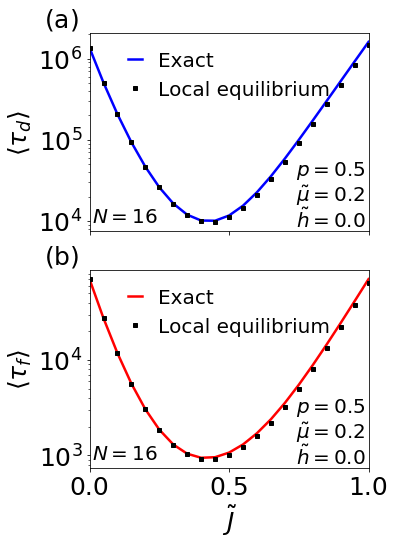

In [14]:
#Figure settings
fig, ax = plt.subplots(2, 1, figsize = (5,8), sharex = True)
ax.ravel()

#Set labels
label1, label2 = 'Exact', 'Local equilibrium'

#Exact results
if full_matrix:
    ax[0].plot(J, exact_MFPTd, linewidth = 2.5, color = 'Blue', label = label1)
    ax[1].plot(J, exact_MFPTf, linewidth = 2.5, color = 'Red',  label = label1)
    
#Local equilibrium results
ax[0].plot(J, leq_MFPTd, linewidth = 0,  markersize = 3.5, marker = 's', color = 'Black', label = label2)
ax[1].plot(J, leq_MFPTf, linewidth = 0,  markersize = 3.5, marker = 's', color = 'Black', label = label2)

#Set axis titles
ax[1].set_xlabel(r'$\tilde{J} $', size = 25)
ax[0].set_ylabel(r'$\langle \tau_{d} \rangle$', size = 25)
ax[1].set_ylabel(r'$\langle \tau_{f} \rangle$', size = 25)

#Set axis scale
ax[0].set_yscale('log')
ax[1].set_yscale('log')

#Set axis limits
ax[0].set_xlim([0,1])
ax[1].set_xlim([0,1])

#Set axis ticks
ax[0].set_xticks([0,0.5,1.0])
ax[1].set_xticks([0,0.5,1.0])

#Set titles
ax[0].set_title(r'$\rm (a)$', fontsize = 25, x = -0.1)
ax[1].set_title(r'$\rm (b)$', fontsize = 25, x = -0.1)

#Set ticks size
labelsize_param = 25
ax[0].tick_params(axis = 'both', which = 'major', labelsize = labelsize_param)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = labelsize_param)

#Legend
legend = ax[0].legend(fontsize = 20, frameon = False, loc = 'upper center', handlelength = 0.7);
legend = ax[1].legend(fontsize = 20, frameon = False, loc = 'upper center', handlelength = 0.7);

#Text
ax[0].text(0.01, 0.12, r'$ N =$' + str(num_bonds), transform = ax[0].transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');
ax[0].text(0.74, 0.36, r'$ p =$' + str(np.round(p,1)), transform = ax[0].transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');
ax[0].text(0.74, 0.24, r'$ \tilde{\mu} =$' + str(np.round(mu,1)), transform = ax[0].transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');
ax[0].text(0.74, 0.12, r'$ \tilde{h} =$' + str(np.round(h/num_bonds,1)), transform = ax[0].transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');
ax[1].text(0.01, 0.12, r'$ N =$' + str(num_bonds), transform = ax[1].transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');
ax[1].text(0.74, 0.36, r'$ p =$' + str(np.round(p,1)), transform = ax[1].transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');
ax[1].text(0.74, 0.24, r'$ \tilde{\mu} =$' + str(np.round(mu,1)), transform = ax[1].transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');
ax[1].text(0.74, 0.12, r'$ \tilde{h} =$' + str(np.round(h/num_bonds,1)), transform = ax[1].transAxes, fontsize = 20, verticalalignment = 'top', color = 'Black');